<a href="https://colab.research.google.com/github/mynhungg/Datamining/blob/Anh-Ki%E1%BB%87t/PhoBERT_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare

## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
path = "/content/drive/MyDrive/Colab Notebooks/PhoBERT_Emotion"
os.chdir(path)

In [3]:
get_ipython().system('ls')

'Screenshot 2023-06-01 000433.png'   UIT-VSMEC


Lệnh **`get_ipython().system('ls')`** được sử dụng trong môi trường Jupyter Notebook hoặc IPython để thực thi lệnh hệ thống **`ls`** (liệt kê các tệp tin và thư mục) và hiển thị kết quả trong ô output của Notebook.

## Download packages

In [4]:
!pip install openpyxl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**`openpyxl`** là một thư viện Python được sử dụng để làm việc với các tệp Excel (**`.xlsx`**). Nó cung cấp các công cụ cho việc đọc, ghi và chỉnh sửa dữ liệu trong các tệp Excel, cho phép thao tác với các bảng tính, các ô và các công thức trong tệp Excel.

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Gói **`transformers`** là một thư viện Python phổ biến được phát triển bởi Hugging Face. Nó cung cấp các công cụ và mô hình để làm việc với xử lý ngôn ngữ tự nhiên (**`NLP`**) và học sâu (**`deep learning`**). Thư viện này cung cấp các mô hình nổi tiếng như **`BERT, GPT, RoBERTa`** và nhiều mô hình khác, và cung cấp các chức năng để tải, huấn luyện và sử dụng những mô hình này trong các tác vụ NLP.

## Import libraries

In [6]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

- **`torch`**: Đây là thư viện PyTorch, một thư viện mã nguồn mở cho việc tính toán số học trên GPU và xây dựng các mô hình học sâu.
- **`numpy as np`**: Thư viện NumPy, được sử dụng để làm việc với mảng và ma trận số học.
- **`pandas as pd`**: Thư viện Pandas, được sử dụng để làm việc với dữ liệu dạng bảng và thực hiện các thao tác xử lý dữ liệu.
- **`seaborn as sns`**: Thư viện Seaborn, được sử dụng để tạo biểu đồ và trực quan hóa dữ liệu.
- **`matplotlib.pyplot as plt`**: Một phần của thư viện Matplotlib, được sử dụng để tạo biểu đồ và trực quan hóa dữ liệu.
- **`gensim.utils.simple_preprocess`**: Một phần của thư viện Gensim, được sử dụng để tiền xử lý văn bản và chuyển đổi văn bản thành các từ đơn giản.
- **`sklearn.model_selection.StratifiedKFold`**: Một phần của thư viện Scikit-learn, được sử dụng để thực hiện phân chia dữ liệu theo Stratified K-Fold cho việc cross-validation.
- **`sklearn.metrics.classification_report`**: Một phần của thư viện Scikit-learn, được sử dụng để tính toán báo cáo phân loại dựa trên các chỉ số như độ chính xác, độ phủ và f1-score.
- **`sklearn.metrics.confusion_matrix`**: Một phần của thư viện Scikit-learn, được sử dụng để tính toán ma trận nhầm lẫn (confusion matrix) cho các bài toán phân loại.
- **`torch.nn`**: Mô-đun trong thư viện PyTorch cho các lớp mô hình và các hàm mất mát (loss functions).
- **`torch.optim.AdamW`**: Một phần của thư viện PyTorch, cung cấp trình tối ưu hóa AdamW.
- **`torch.utils.data.Dataset, torch.utils.data.DataLoader`**: Các phần của thư viện PyTorch dùng để xây dựng và tải dữ liệu vào mô hình.
- **`transformers`**: Thư viện Hugging Face Transformers, được sử dụng để làm việc với các mô hình NLP đã được huấn luyện trước (pretrained models) như BERT, GPT, RoBERTa, và các hàm tiện ích liên quan.
- **`warnings`**: Một mô-đun trong Python để quản lý cảnh báo và thông báo trong quá trình chạy mã.

## Function definition

In [7]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

Đoạn mã trên định nghĩa một hàm **`seed_everything`** để thiết lập các giá trị hạt giống (seed) cho việc tái lặp lại (reproducibility) quá trình huấn luyện mô hình. Dưới đây là ý nghĩa của từng dòng mã trong hàm:

- **`np.random.seed(seed_value)`**: Thiết lập giá trị hạt giống cho thư viện NumPy để tái lặp lại các phép ngẫu nhiên.
- **`torch.manual_seed(seed_value)`**: Thiết lập giá trị hạt giống cho thư viện PyTorch để tái lặp lại các phép ngẫu nhiên.
- **`if torch.cuda.is_available()`**: Kiểm tra xem có sử dụng GPU (CUDA) hay không.
- **`torch.cuda.manual_seed(seed_value)`**: Thiết lập giá trị hạt giống cho CUDA để tái lặp lại các phép ngẫu nhiên trên GPU.
- **`torch.cuda.manual_seed_all(seed_value)`**: Thiết lập giá trị hạt giống cho tất cả các thiết bị CUDA (nếu có).
- **`torch.backends.cudnn.deterministic = True`**: Đặt chế độ xác định (deterministic) cho việc sử dụng thư viện cuDNN trên GPU. Điều này đảm bảo kết quả của các phép tính trên GPU là nhất quán và tái lặp lại được.
- **`torch.backends.cudnn.benchmark = True`**: Đặt chế độ benchmark cho việc sử dụng thư viện cuDNN trên GPU. Điều này cho phép PyTorch tự động tinh chỉnh cấu hình cuDNN để tối ưu hóa hiệu suất.

Bằng cách thiết lập các giá trị hạt giống như trên, ta có thể đảm bảo rằng quá trình huấn luyện mô hình sẽ cho ra kết quả nhất quán và có thể tái lặp lại được khi chạy nhiều lần.

In [8]:
seed_everything(86)

In [9]:
def get_data(path):
    df = pd.read_excel(path, sheet_name='Sheet1')
    df.columns = ['index', 'Emotion', 'Sentence']
    df.drop(columns=['index'], inplace=True)
    return df

Hàm **`get_data`** trong đoạn mã trên nhận đầu vào là đường dẫn tới tệp Excel và trả về một dataframe chứa dữ liệu.

Các bước trong hàm **`get_data`** là như sau:

1. **`df = pd.read_excel(path, sheet_name='Sheet1')`**: Đọc tệp Excel từ đường dẫn **`path`** và lưu dữ liệu vào dataframe **`df`**. Tham số **`sheet_name='Sheet1'`** chỉ định rằng dữ liệu được đọc từ sheet có tên là 'Sheet1'.
2. **`df.columns = ['index', 'Emotion', 'Sentence']`**: Đặt tên cột cho dataframe **`df`** thành ['index', 'Emotion', 'Sentence']. Các cột này tương ứng với các cột trong tệp Excel.
3. **`df.drop(columns=['index'], inplace=True)`**: Xóa cột 'index' khỏi dataframe **`df`** vì không cần thiết.
4. **`return df`**: Trả về dataframe **`df`** đã xử lý.

In [10]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

Hàm **`train`** được sử dụng để huấn luyện mô hình. Các tham số đầu vào bao gồm:

- **`model`**: Mô hình **`SentimentClassifier`** đã được khởi tạo.
- **`criterion`**: Hàm mất mát để tính toán độ lỗi (ví dụ: **`nn.CrossEntropyLoss`**).
- **`optimizer`**: Bộ tối ưu hóa được sử dụng để cập nhật trọng số của mô hình (ví dụ: **`AdamW`**).
- **`train_loader`**: **`DataLoader`** chứa dữ liệu huấn luyện.

Trong quá trình huấn luyện, các bước sau được thực hiện:

- Đặt mô hình vào chế độ huấn luyện bằng cách gọi **`model.train()`**.
- Khởi tạo biến **`losses`** để lưu trữ giá trị mất mát từ các batch.
- Khởi tạo biến **`correct`** để lưu trữ số lượng dự đoán chính xác.
- Với mỗi batch trong **`train_loader`**, thực hiện các bước sau:
  - Di chuyển dữ liệu vào GPU (nếu có) bằng cách gọi **`to(device)`**.
  - Xóa các gradient trước khi tính toán backward bằng **`optimizer.zero_grad()`**.
  - Đưa dữ liệu qua mô hình để có đầu ra (**`outputs`**).
  - Tính toán giá trị mất mát bằng cách so sánh đầu ra và nhãn thật (**`targets`**) thông qua **`criterion`**.
  - Dùng **`torch.max`** để lấy ra nhãn dự đoán có giá trị lớn nhất.
  - Cập nhật biến **`correct`** bằng cách tính toán số lượng dự đoán chính xác.
  - Lưu trữ giá trị mất mát vào biến **`losses`**.
  - Tính gradient và cập nhật trọng số mô hình thông qua **`loss.backward()`** và **`optimizer.step()`**.
  - Áp dụng quá trình điều chỉnh learning rate thông qua **`lr_scheduler.step()`** (nếu có).
  
Cuối cùng, hàm in ra thông tin về độ chính xác trên tập huấn luyện và giá trị trung bình của mất mát (**`np.mean(losses)`**).

In [11]:
def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

Hàm **`eval`** được sử dụng để đánh giá hiệu suất của mô hình trên tập kiểm tra hoặc tập xác thực. Các tham số đầu vào bao gồm:

- **`test_data`**: Một cờ boolean xác định liệu ta đang đánh giá trên tập kiểm tra (**`True`**) hay tập xác thực (**`False`**).

Trong quá trình đánh giá, các bước sau được thực hiện:

- Đặt mô hình vào chế độ đánh giá bằng cách gọi **`model.eval()`**.
- Khởi tạo biến **`losses`** để lưu trữ giá trị mất mát từ các batch.
- Khởi tạo biến **`correct`** để lưu trữ số lượng dự đoán chính xác.
- Sử dụng **`torch.no_grad()`** để tắt tính toán gradient.
- Chọn **`data_loader`** tương ứng (từ **`test_loader`** hoặc **`valid_loader`**) dựa trên giá trị của **`test_data`**.
- Với mỗi batch trong **`data_loader`**, thực hiện các bước sau:
  - Di chuyển dữ liệu vào GPU (nếu có) bằng cách gọi **`to(device)`**.
  - Đưa dữ liệu qua mô hình để có đầu ra (**`outputs`**).
  - Dùng **`torch.max`** để lấy ra nhãn dự đoán có giá trị lớn nhất.
  - Tính toán giá trị mất mát bằng cách so sánh đầu ra và nhãn thật thông qua **`criterion`**.
  - Cập nhật biến **`correct`** bằng cách tính toán số lượng dự đoán chính xác.
  - Lưu trữ giá trị mất mát vào biến **`losses`**.

Cuối cùng, hàm in ra thông tin về độ chính xác trên tập kiểm tra hoặc tập xác thực và giá trị trung bình của mất mát (**`np.mean(losses)`**). Hàm trả về độ chính xác tính được trên tập kiểm tra hoặc tập xác thực.

In [12]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

Hàm **`prepare_loaders`** được sử dụng để chuẩn bị các DataLoader cho việc huấn luyện và đánh giá trên mỗi fold. Các tham số đầu vào bao gồm:

- **`df`**: DataFrame chứa dữ liệu huấn luyện đã được gán fold.
- **`fold`**: Fold hiện tại đang được xử lý.

Các bước thực hiện trong hàm là:

- Tách DataFrame **`df`** thành **`df_train`** và **`df_valid`** dựa trên fold hiện tại.
- Tạo đối tượng **`train_dataset`** và **`valid_dataset`** từ **`df_train`** và **`df_valid`** sử dụng lớp **`SentimentDataset`**.
- Tạo DataLoader **`train_loader`** và **`valid_loader`** từ **`train_dataset`** và **`valid_dataset`** với các thông số:
  - **`batch_size=16`**: Số lượng mẫu trong mỗi batch.
  - **`shuffle=True`**: Xáo trộn dữ liệu trước khi tạo batch.
  - **`num_workers=2`**: Số luồng xử lý dữ liệu song song.

Cuối cùng, hàm trả về **`train_loader`** và **`valid_loader`** để sử dụng trong quá trình huấn luyện và đánh giá.

In [13]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

Hàm **`test`** được sử dụng để đánh giá mô hình trên dữ liệu kiểm tra hoặc dữ liệu mới. Các bước thực hiện trong hàm **`test`** là:

- Khởi tạo một danh sách **`models`** để lưu trữ các mô hình đã được huấn luyện trên các fold trước đó.
- Vòng lặp qua các fold để tải và tạo mô hình từ trạng thái đã lưu.
- Thiết lập mô hình ở chế độ đánh giá bằng cách gọi **`model.eval()`**.
- Tạo các danh sách để lưu trữ dữ liệu về văn bản, dự đoán, xác suất dự đoán và giá trị thực của các mẫu.
- Vòng lặp qua từng mẫu trong **`data_loader`**.
  - Lấy thông tin văn bản, đầu vào **`input_ids`**, **`attention_mask`** và giá trị thực **`targets`**.
  - Tạo danh sách **`total_outs`** để lưu trữ đầu ra của các mô hình trên từng fold.
  - Vòng lặp qua các mô hình trong **`models`**.
    - Sử dụng mô hình để tính toán đầu ra cho mẫu đầu vào.
    - Lưu trữ đầu ra vào danh sách **`total_outs`**.
  - Chuyển đổi danh sách **`total_outs`** thành tensor và tính toán dự đoán cuối cùng bằng cách lấy giá trị lớn nhất trung bình.
  - Gắn kết thông tin văn bản, dự đoán, xác suất dự đoán và giá trị thực vào các danh sách tương ứng.
- Chuyển đổi dự đoán, xác suất dự đoán và giá trị thực thành tensor trên CPU.
- In báo cáo phân loại bằng cách gọi **`classification_report`** từ **`sklearn.metrics`**.
- Trả về các tensor **`real_values`** (giá trị thực) và **`predicts`** (dự đoán).

In [14]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

Hàm **`check_wrong`** được sử dụng để kiểm tra các trường hợp dự đoán sai của mô hình.

- Đầu vào của hàm là **`real_values`** (giá trị thực) và **`predicts`** (dự đoán).
- Hàm sẽ duyệt qua từng phần tử trong **`predicts`** và so sánh với giá trị tương ứng trong **`real_values`**.
- Nếu dự đoán không khớp với giá trị thực, vị trí của phần tử đó sẽ được thêm vào danh sách **`wrong_arr`**, và dự đoán sai sẽ được thêm vào danh sách **`wrong_label`**.
- Cuối cùng, hàm trả về **`wrong_arr`** (danh sách các vị trí dự đoán sai) và **`wrong_label`** (danh sách các dự đoán sai).

In [15]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

Đoạn code trên định nghĩa một hàm **`infer`** để dự đoán cảm xúc của một câu văn mới bằng cách sử dụng mô hình đã được huấn luyện. 

Hàm **`infer`** nhận vào các đối số sau:
- **`text`**: Đây là câu văn cần dự đoán cảm xúc.
- **`tokenizer`**: Đối tượng tokenizer được sử dụng để mã hóa câu văn thành dạng phù hợp cho mô hình.
- **`max_len`**: Độ dài tối đa của câu văn sau khi mã hóa.

Trước tiên, câu văn **`text`** được mã hóa bằng cách sử dụng tokenizer. Quá trình mã hóa này bao gồm thêm các token đặc biệt vào câu văn, cắt ngắn hoặc bổ sung các token để đảm bảo độ dài của câu văn không vượt quá **`max_len`**, và tạo các tensor đại diện cho câu văn (bao gồm tensor **`input_ids`** và **`attention_mask`**).

Tiếp theo, câu văn được đưa vào mô hình để dự đoán cảm xúc. Mô hình trả về một tensor chứa xác suất dự đoán cho từng lớp cảm xúc. Bằng cách sử dụng hàm **`torch.max`**, ta lấy chỉ số của lớp có xác suất dự đoán cao nhất (**`y_pred`**).

Cuối cùng, hàm **`infer`** in ra câu văn ban đầu (**`text`**) và cảm xúc dự đoán tương ứng (**`class_names[y_pred]`**). **`class_names`** là danh sách các nhãn cảm xúc tương ứng với các lớp.

Bằng cách sử dụng hàm **`infer`**, ta có thể dễ dàng dự đoán cảm xúc của các câu văn mới bằng cách gọi hàm và truyền vào câu văn cần dự đoán.

## Class definition

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])

        return text, label

Lớp **`SentimentDataset`** là một lớp con của **`torch.utils.data.Dataset`**, được sử dụng để tạo ra một tập dữ liệu tùy chỉnh cho nhiệm vụ phân loại cảm xúc (sentiment classification).

Các phương thức chính trong lớp **`SentimentDataset`** bao gồm:

- **`__init__(self, df, tokenizer, max_len=120)`**: Phương thức khởi tạo của lớp, nhận vào dataframe **`df`** chứa dữ liệu huấn luyện, tokenizer **`tokenizer`** và độ dài tối đa **`max_len`** của câu.
- **`__len__(self)`**: Phương thức trả về số lượng mẫu trong tập dữ liệu.
- **`__getitem__(self, index)`**: Phương thức trả về một mẫu dữ liệu tại vị trí **`index`**. Phương thức này thực hiện tiền xử lý văn bản, mã hóa văn bản thành các mã token và trả về một từ điển chứa thông tin của mẫu dữ liệu, bao gồm **`input_ids`** (mã token), **`attention_masks`** (mặt nạ chú ý), **`text`** (văn bản gốc) và **`targets`** (nhãn).
- **`labelencoder(self, text)`**: Phương thức chuyển đổi nhãn từ dạng văn bản sang số nguyên. Các nhãn được mã hóa như sau: **`Enjoyment`**: 0, **`Disgust`**: 1, **`Sadness`**: 2, **`Anger`**: 3, **`Surprise`**: 4, **`Fear`**: 5, **`Khác`**: 6.
- **`get_input_data(self, row)`**: Phương thức thực hiện xử lý dữ liệu đầu vào từ một hàng dữ liệu trong dataframe **`df`**. Nó loại bỏ các ký tự đặc biệt, chuyển đổi văn bản thành dạng lowercase và trả về văn bản và nhãn tương ứng.

Lớp **`SentimentDataset`** cho phép tạo ra các đối tượng tập dữ liệu tuỳ chỉnh để huấn luyện và đánh giá mô hình phân loại cảm xúc.

In [17]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

Lớp **`SentimentClassifier`** là một mô hình phân loại cảm xúc dựa trên kiến trúc của RoBERTa. Cụ thể:

- **`n_classes`**: Số lượng lớp đầu ra (số lượng cảm xúc khác nhau).

Phương thức **`__init__`**:
- Khởi tạo mô hình RoBERTa (**`self.bert`**) từ pretrained weights của bộ mã hóa PhoBERT.
- Áp dụng Dropout với xác suất 0.3 (**`self.drop`**) để tránh overfitting.
- Tạo một lớp tuyến tính (**`self.fc`**) với kích thước đầu ra bằng **`n_classes`** và khởi tạo các trọng số ngẫu nhiên theo phân phối chuẩn.

Phương thức **`forward`**:
- Đầu vào của mô hình là **`input_ids`** (chuỗi các mã token) và **`attention_mask`** (mảng chỉ định phần tử thực tế và padding trong câu).
- Mô hình RoBERTa được áp dụng cho đầu vào và trả về kết quả cuối cùng và hidden state (**`last_hidden_state`**, **`output`**).
- Đầu ra từ RoBERTa được truyền qua Dropout layer và sau đó thông qua một lớp tuyến tính để đưa ra dự đoán cho từng lớp.

Lớp **`SentimentClassifier`** là một lớp con của lớp **`nn.Module`** trong PyTorch và triển khai phương thức **`forward`** để thực hiện feedforward qua mô hình.

## Parameter definition

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

- **`device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')`**: Dòng này xác định thiết bị tính toán mà PyTorch sẽ sử dụng. Nếu CUDA (GPU) khả dụng, thiết bị sẽ được đặt là 'cuda:0' (thiết bị GPU đầu tiên), ngược lại nó sẽ được đặt là 'cpu' (thiết bị CPU).
- **`EPOCHS = 6`**: Biến EPOCHS định nghĩa số lượng epochs (vòng lặp huấn luyện) mà mô hình sẽ được huấn luyện qua.
- **`N_SPLITS = 5`**: Biến N_SPLITS định nghĩa số lượng phân chia (splits) trong quá trình cross-validation (kiểm định chéo). Đây là số lượng phần chia dữ liệu huấn luyện và kiểm tra mà mô hình sẽ được huấn luyện và đánh giá trên. Trong trường hợp này, có tổng cộng 5 phân chia.

# 2. Load data

## Dataset Introduction

Dataset được lấy trong bài báo: **Emotion Recognition
for Vietnamese Social Media Text"** của nhóm tác giả Vong Anh Ho, Duong Huynh-Cong Nguyen, Danh Hoang Nguyen, Linh Thi-Van Pham, Duc-Vu Nguyen, Kiet Van Nguyen, Ngan Luu-Thuy Nguyen.
Link bài báo: https://arxiv.org/pdf/1911.09339.pdf
![image.png](https://th.bing.com/th/id/R.3919507c4109750a00952538e4953427?rik=4fcsgGs3sz633A&pid=ImgRaw&r=0)


In [19]:
train_df = get_data('/content/drive/MyDrive/Colab Notebooks/PhoBERT_Emotion/UIT-VSMEC/train_nor_811.xlsx')
valid_df = get_data('/content/drive/MyDrive/Colab Notebooks/PhoBERT_Emotion/UIT-VSMEC/valid_nor_811.xlsx')
test_df = get_data('/content/drive/MyDrive/Colab Notebooks/PhoBERT_Emotion/UIT-VSMEC/test_nor_811.xlsx')

In [20]:
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)

for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

Đoạn mã trên thực hiện quá trình chia dữ liệu thành các phần chia kiểm định sử dụng StratifiedKFold.

Các bước trong đoạn mã là như sau:

1. **`train_df = pd.concat([train_df, valid_df], ignore_index=True)`**: Kết hợp dataframe train_df và valid_df lại thành một dataframe duy nhất. Tham số **`ignore_index=True`** được sử dụng để đặt lại chỉ mục của các dòng trong dataframe kết hợp.
2. **`skf = StratifiedKFold(n_splits=N_SPLITS)`**: Khởi tạo một đối tượng StratifiedKFold với số lượng phần chia kiểm định là N_SPLITS.
3. **`for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion))`**: Sử dụng vòng lặp for để duyệt qua các fold được tạo bởi StratifiedKFold. Biến fold đại diện cho số thứ tự của fold, còn (_, val_) đại diện cho chỉ mục của các dữ liệu huấn luyện và dữ liệu kiểm định trong fold hiện tại.
4. **`train_df.loc[val_, "kfold"] = fold`**: Đánh dấu các dữ liệu có chỉ mục là val_ trong cột "kfold" của dataframe train_df với giá trị của fold hiện tại.

In [21]:
train_df.sample(5)

,Emotion,Sentence,kfold
3706,Enjoyment,dễ thương ghê ! làm mình nhớ các cậu bạn cùng ...,2.0
3913,Enjoyment,đáng yêuc vãi anh ơi,3.0
234,Surprise,bất ngờ chưa =))),0.0
658,Surprise,cha con y chang nhau 😂 1 khuôn đúc ra,0.0
821,Enjoyment,lợi ích của việc giữ vững quan điểm 😄,0.0


# 3. Data visualization

In [22]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   6234 non-null   object 
 1   Sentence  6234 non-null   object 
 2   kfold     6234 non-null   float64
dtypes: float64(1), object(2)
memory usage: 146.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

Phương thức **`.info()`** sẽ hiển thị thông tin tổng quan về dataframe bao gồm số lượng dòng, số lượng cột, các kiểu dữ liệu của các cột và thông tin về lượng bộ nhớ được sử dụng.

<Axes: xlabel='Emotion', ylabel='count'>

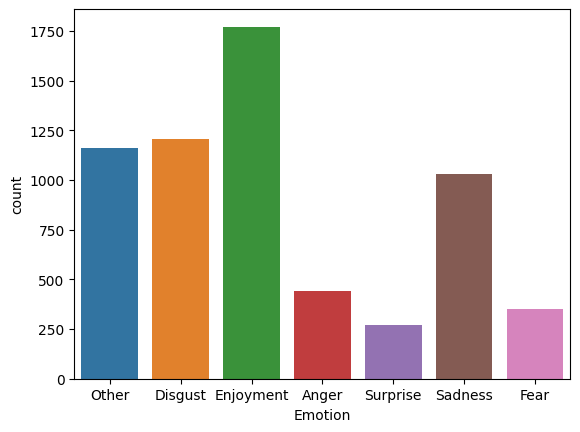

In [23]:
sns.countplot(x='Emotion', data=train_df)

Đoạn mã trên sẽ tạo ra một biểu đồ cột (bar chart) với trục **x** là cột **'`Emotion`'** và đếm số lượng các mẫu tương ứng.

# 4. Tokenization using PhoBERT

In [24]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Đoạn mã trên sử dụng thư viện **`transformers`** để tải và khởi tạo một tokenizer từ mô hình **`vinai/phobert-base`**.

Trong đó:
- **`"vinai/phobert-base"`** là tên của mô hình PhoBERT được cung cấp bởi VinAI Research.
- **`use_fast=False`** được sử dụng để tải tokenizer theo chế độ không sử dụng các cải tiến nhanh của Hugging Face. Mặc định là **`True`**, nhưng khi chọn **`False`**, việc tải tokenizer có thể mất nhiều thời gian hơn nhưng sẽ tiết kiệm bộ nhớ.

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.

Text(0.5, 12.44444444444443, 'Token Count')

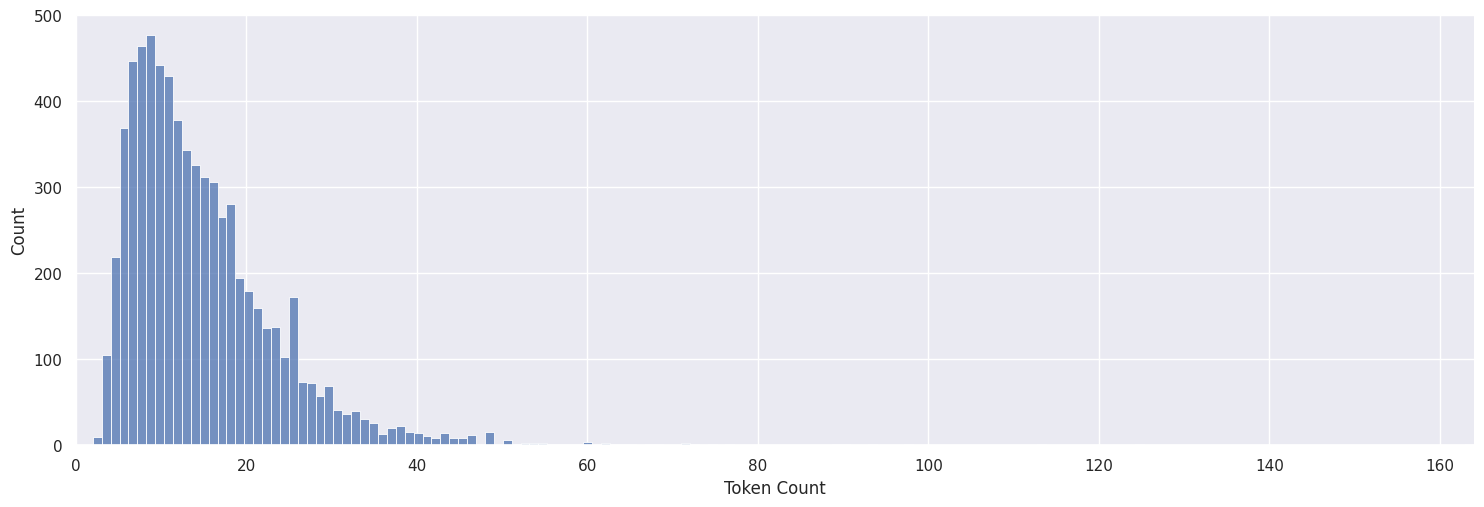

In [25]:
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(token_lens, height=5, aspect=3)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

Đoạn mã trên tạo ra biểu đồ phân phối độ dài của các câu sau khi mã hóa thành mã token bằng tokenizer. Cụ thể:

- **`all_data`**: Là danh sách chứa tất cả các câu trong tập huấn luyện và tập kiểm tra, đã được chuyển đổi thành dạng lowercase và loại bỏ các ký tự đặc biệt.
- **`encoded_text`**: Là danh sách chứa các câu đã được mã hóa thành mã token bằng tokenizer.
- **`token_lens`**: Là danh sách chứa độ dài của mỗi câu sau khi mã hóa thành mã token.

Biểu đồ được tạo bằng thư viện Seaborn và matplotlib, hiển thị phân phối của độ dài câu dựa trên số lượng token. Biểu đồ giúp chúng ta hiểu được phân phối của độ dài câu và có thể hữu ích trong việc định cấu hình độ dài tối đa cho mô hình.

==> Chọn chiều dài tối đa là 50 là an toàn

# 5. Training

**Training with K-Fold**

In [26]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.37617806296370565 Loss: 1.6341180690588095
Valid Accuracy: 0.5252606255012029 Loss: 1.305380669159767
Epoch 2/6
------------------------------
Train Accuracy: 0.5766994184880689 Loss: 1.2167388731852555
Valid Accuracy: 0.5926222935044105 Loss: 1.1947218439517877
Epoch 3/6
------------------------------
Train Accuracy: 0.6667335071185081 Loss: 0.9773907526754416
Valid Accuracy: 0.5998396150761829 Loss: 1.1708458952414684
Epoch 4/6
------------------------------
Train Accuracy: 0.7300982554642069 Loss: 0.8013667154770631
Valid Accuracy: 0.6134723336006416 Loss: 1.116731882477418
Epoch 5/6
------------------------------
Train Accuracy: 0.7876478844996992 Loss: 0.6628419832350352
Valid Accuracy: 0.6142742582197274 Loss: 1.1536177438803208
Epoch 6/6
------------------------------
Train Accuracy: 0.8215359935833166 Loss: 0.5722139111887186
Valid Accuracy: 0.6222935044105854 Loss: 1.16178057934993

Đoạn mã trên thực hiện quá trình huấn luyện và đánh giá mô hình trên mỗi fold. Các bước thực hiện trong mỗi fold là:

- In thông báo về fold hiện tại.
- Chuẩn bị DataLoader huấn luyện và DataLoader đánh giá bằng cách gọi hàm **`prepare_loaders`**.
- Khởi tạo mô hình **`SentimentClassifier`** với số lớp đầu ra là 7 và đưa mô hình vào thiết bị **`device`**.
- Định nghĩa hàm mất mát **`criterion`** là **`nn.CrossEntropyLoss()`**.
- Tạo bộ tối ưu hóa **`optimizer`** bằng cách sử dụng **`AdamW`** với tỷ lệ học **`lr`** là 2e-5.
- Tạo lịch biến đổi tỷ lệ học **`lr_scheduler`** bằng cách sử dụng **`get_linear_schedule_with_warmup`**.
- Khởi tạo biến **`best_acc`** để lưu giữ độ chính xác tốt nhất trên tập đánh giá.
- Bắt đầu vòng lặp qua các epoch.
  - In thông báo về epoch hiện tại.
  - Huấn luyện mô hình bằng cách gọi hàm **`train`**.
  - Đánh giá mô hình trên tập đánh giá bằng cách gọi hàm **`eval`**.
  - Nếu độ chính xác trên tập đánh giá (**`val_acc`**) vượt qua độ chính xác tốt nhất trước đó (**`best_acc`**), lưu trạng thái của mô hình vào file **`phobert_fold{fold+1}.pth`** và cập nhật **`best_acc`**.

Đoạn mã trên thực hiện huấn luyện và lưu trạng thái tốt nhất của mô hình trên mỗi fold, mỗi fold được lưu vào một tệp tin riêng biệt với tên **`phobert_fold{fold+1}.pth`**.

# 6. Testing

In [27]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       193
           1       0.60      0.59      0.60       132
           2       0.65      0.65      0.65       116
           3       0.41      0.35      0.38        40
           4       0.65      0.41      0.50        37
           5       0.65      0.67      0.66        46
           6       0.52      0.59      0.55       129

    accuracy                           0.60       693
   macro avg       0.59      0.56      0.57       693
weighted avg       0.61      0.60      0.60       693



- Dòng đầu tiên tạo một đối tượng **`test_dataset`** từ **`test_df`**, sử dụng **`SentimentDataset`** để chuyển đổi dữ liệu kiểm tra thành dữ liệu có thể đưa vào mô hình. Đối tượng **`test_dataset`** được cấu hình với tokenizer và độ dài tối đa của câu là 50.

- Dòng thứ hai tạo một **`test_loader`** từ **`test_dataset`** để tạo ra các batch dữ liệu kiểm tra. **`test_loader`** có kích thước batch là 16, được xáo trộn (**`shuffle=True`**) và sử dụng 2 worker để tải dữ liệu song song (**`num_workers=2`**).

- Dòng thứ ba gọi hàm **`test`** và truyền **`test_loader`** vào để thực hiện dự đoán trên dữ liệu kiểm tra. Hàm **`test`** sẽ sử dụng các mô hình đã được huấn luyện trên từng fold để dự đoán và trả về giá trị thực (**`real_values`**) và dự đoán (**`predicts`**).

Với **`real_values`** và **`predicts`**, ta có thể tiến hành mô tả và đánh giá hiệu suất của mô hình trên tập dữ liệu kiểm tra bằng cách tính toán các độ đo như precision, recall và f1-score.

**Heatmap between Predict and Ground Truth**

<Axes: >

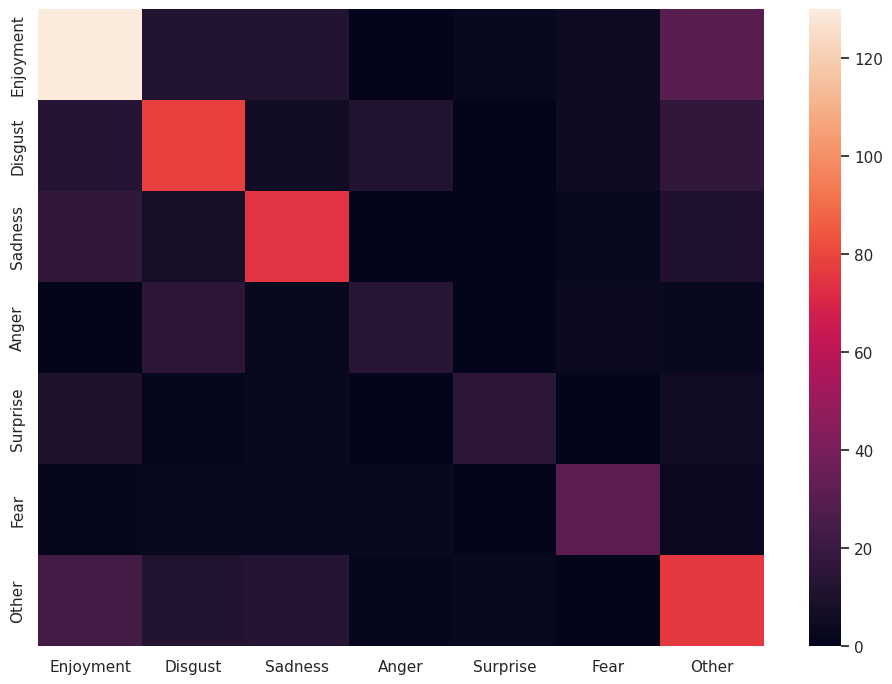

In [28]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

Đoạn mã trên tạo một heatmap sử dụng confusion matrix để hiển thị các dự đoán và giá trị thực của mô hình trên tập dữ liệu kiểm tra. 

- **`class_names`** là danh sách các lớp hoạt động (emotions) được định nghĩa là **`['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']`**. 
- **`confusion_matrix(real_values, predicts)`** tính ma trận nhầm lẫn giữa các dự đoán (**`predicts`**) và giá trị thực (**`real_values`**).
- **`sns.heatmap(...)`** sử dụng seaborn để vẽ heatmap với các giá trị trong ma trận nhầm lẫn. 
  - **`annot=False`** để không hiển thị các giá trị trên heatmap.
  - **`xticklabels`** và **`yticklabels`** được đặt thành **`class_names`** để hiển thị tên của các lớp hoạt động trên các trục x và y của heatmap.

=> Nhãn Fear không có quan hệ với các nhãn khác -> F1-Score cao nhất

In [29]:
for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Other) --vs-- Real label: (Disgust)
--------------------------------------------------
nhà thì không xa lắm nhưng chưa bao giờ đi vì sợ bị đè bẹp luôn người =)))))
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
bố không thích nộp đấy mày thích ý kiến không
Predicted: (Anger) --vs-- Real label: (Disgust)
--------------------------------------------------
một hành động đẹp đầy tính nhân văn ☺️☺️
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
mấy ai được như vậy ??
Predicted: (Other) --vs-- Real label: (Sadness)
--------------------------------------------------
sống 17 năm chưa crush ai bao giờ
Predicted: (Disgust) --vs-- Real label: (Enjoyment)
--------------------------------------------------
ổng quay thiệt mà sao chửi ổng thế . không quay sao máy bạn xem được đó :))
Predicte

Trong vòng lặp trên, chúng ta sử dụng hàm **`check_wrong`** để lấy danh sách các vị trí dự đoán sai (**`wrong_arr`**) và danh sách các dự đoán sai (**`wrong_label`**). Sau đó, chúng ta in ra câu văn bị dự đoán sai từ **`test_df`**, dự đoán sai (**`wrong_label`**), và nhãn thực tế (**`real_values`**) tương ứng với câu văn đó.

# 7. Inference

In [30]:
infer('Thật là vui vì cuối cùng đã hoàn thành công việc', tokenizer)

Text: Thật là vui vì cuối cùng đã hoàn thành công việc
Sentiment: Enjoyment


In [31]:
infer('Rớt môn rồi, tôi buồn quá', tokenizer)

Text: Rớt môn rồi, tôi buồn quá
Sentiment: Sadness


In [32]:
infer('Tại sao lại đến trễ, thật bực mình', tokenizer)

Text: Tại sao lại đến trễ, thật bực mình
Sentiment: Sadness


In [33]:
infer('Ồ! ở đó có nhiều vàng vậy hả?', tokenizer)

Text: Ồ! ở đó có nhiều vàng vậy hả?
Sentiment: Surprise


In [34]:
infer('Cái đó nhìn ghê quá!', tokenizer)

Text: Cái đó nhìn ghê quá!
Sentiment: Fear


In [35]:
infer('Cái đó nhìn ghê quá!', tokenizer)

Text: Cái đó nhìn ghê quá!
Sentiment: Fear


In [36]:
infer('Bộ phim này chán quá', tokenizer)

Text: Bộ phim này chán quá
Sentiment: Disgust


In [37]:
infer('Em yêu Hệ thống', tokenizer)

Text: Em yêu Hệ thống
Sentiment: Enjoyment


In [38]:
infer('Tôi không hiểu bộ phim đang nói về vấn đề gì', tokenizer)

Text: Tôi không hiểu bộ phim đang nói về vấn đề gì
Sentiment: Other
